In [1]:
# reproduce f from knn or sigmoid

# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
import os
from sklearn.metrics import f1_score
"""ppi.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1i8xRqB1bvfLoTvICrMtHFuvKqdvU5x6D
"""

# !pip install dgl-cu101

import dgl
from dgl.data.ppi import PPIDataset

from dgl.data.ppi import LegacyPPIDataset
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import sys
import argparse 
from transfers.utils import gen_graph, generate_graph
from types import SimpleNamespace
from sage import SAGECompletedGraph
import time
import random
import string

args = {
    "lam": 1.1,
    "mu": 100,
    "p": 8,
    "n": 32,
    "seed": 100,
    "kind": "sigmoid",
    "k": 8,
    "n_graphs": 128,
    "epochs": 1000,
    "batch_size": 8,
    "beta": 5,
    "alpha": 1.0,
}

In [2]:
args = SimpleNamespace(**args)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [3]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv1d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class GNN(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 hidden_channels,
                 num_classes,
                 normalize=False,
                 add_loop=True):
        super(GNN, self).__init__()
        self.add_loop = add_loop
        self.conv1 = SAGECompletedGraph(in_channels, hidden_channels, normalize)
        self.conv2 = SAGECompletedGraph(hidden_channels, num_classes, normalize)

    def forward(self, x, adj, mask=None):
        batch_size, num_nodes, in_channels = x.size()
        x = F.relu(self.conv1(x, adj, mask, self.add_loop))
        x = F.relu(self.conv2(x, adj, mask, self.add_loop))
        return F.log_softmax(x, dim=1)

class ModelSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        d = args.n*(args.n-1)//2
        self.d = d
        name = ''.join([random.choice(string.ascii_letters + string.digits) for n in range(4)])
        layers = [
            (f'{name}-linear1', nn.Linear(d, d*2)),
            (f'{name}-relu1', nn.ELU()),
#             (f'{name}-linear2', nn.Linear(d*2, d*2)),
#             (f'{name}-relu2', nn.ReLU()),
#             (f'{name}-linear3', nn.Linear(d*2, d*2)),
#             (f'{name}-relu3', nn.ReLU()),
            (f'{name}-linear4', nn.Linear(d*2, d)),
        ]
        self.W = nn.Sequential()
        [self.W.add_module(n, l) for n, l in layers]
        self.W.apply(init_weights)
    def forward_shuffle(self, Xs, halfAs):
        inds = np.random.permutation(len(Xs))
        Xs = [Xs[x] for x in inds]
        halfAs = [halfAs[x] for x in inds]
        return self.forward(Xs), torch.stack(halfAs,dim=0)
    def forward(self, Xs):
        xs = [torch.FloatTensor(x).to(device) for x in Xs]
        xs = [torch.pdist(x) for x in xs]
        xs = torch.stack(xs, dim=0)
        xs = self.W(xs)
        xs = 1 - torch.sigmoid(xs) # lower the distance, higher probabilitity of edge
        return xs
    def predict_adj(self, Xs, absolute=True):
        xs = self.forward(Xs)
        if absolute:
            xs[xs < 0.5] = 0
            xs[xs >= 0.5] = 1
        return xs
        
def weighted_cross_entropy_with_logits(logits, targets, beta):
    l=logits
    t=targets
    loss= -(beta*t*torch.log(torch.sigmoid(l)+1e-10) + (1-beta)*(1-t)*torch.log(torch.sigmoid(1-l)+1e-10))
    return loss

def compute_f1(pA, A, absolute=False):
    pA = pA.detach().cpu().numpy().astype(np.int)
    A = A.cpu().numpy().astype(np.int)
    if absolute:
        pA[pA >= 0.5] = 1
        pA[pA < 0.5] = 0
    f1 = f1_score(A, pA, average="macro")
    return f1

def f1_gnn(ypred, ytrue):
    ypred = ypred.detach().cpu().numpy().astype(np.int)
    ypred = np.argmax(ypred, axis=1)
    ytrue = ytrue.cpu().numpy().astype(np.int)
    f1 = f1_score(ytrue, ypred, average="micro")
    return f1

def batch_pdist_to_adjs(batch_halfAs):
    batch_adjs = torch.zeros((len(batch_halfAs), args.n, args.n)).to(device)
    for i,halfA in enumerate(batch_halfAs):
        inds = torch.triu(torch.ones(args.n, args.n)) 
        inds[torch.arange(args.n), torch.arange(args.n)] = 0
        batch_adjs[i][inds == 1] = halfA
        batch_adjs[i] = batch_adjs[i].T + batch_adjs[i]
    return batch_adjs

def halfA_to_A(halfA):
    A = np.zeros((len(X), len(X)))
    inds = torch.triu(torch.ones(len(A),len(A))) 
    inds[np.arange(len(A)), np.arange(len(A))] = 0
    A[inds == 1] = halfA
    A = A + A.T
    A[np.arange(len(A)), np.arange(len(A))] = 1
    return A

In [4]:
graphs = []
train_size = args.n_graphs - 2
u = np.random.multivariate_normal(np.zeros((args.p)), np.eye(args.p)/args.p, 1)
print("u", u)
for i in range(args.n_graphs):
    if i%100 == 0: print(f"{i+1}/{args.n_graphs}")
    _, X, L = gen_graph(n=args.n, p=args.p, lam=args.lam, mu=args.mu, u=u)
#     torch.FloatTensor(np.random.randint(2, size=(args.n*(args.n-1)//2)))
    graphs.append((None, X, L, None))
train_graphs = graphs[:train_size]
test_graphs = graphs[train_size:]

u [[-0.61863552  0.12115582  0.40765972 -0.08924962  0.34694929  0.18180381
   0.07819882 -0.37831745]]
1/128
101/128


In [9]:
from itertools import chain
model1 = ModelSigmoid().to(device) # function F
print(model1)
model_gnn = GNN(args.p, args.p*2, 2).to(device) # use to learn model1
# optim = torch.optim.Adam(chain(model1.parameters(), model_gnn.parameters()), lr=0.01) # weight_decay=5e-4
optim = torch.optim.Adam(
    [
        {'params': model1.parameters(), 'lr': 5e-4},
        {'params': model_gnn.parameters()}
    ],
    lr=0.01
)

def loss_reverse_distance(predAs):
#     predAs BxP
    return -torch.pdist(predAs).mean()

def loss_shuffle_features(xs):
    xs = [x.detach().cpu().numpy() for x in xs]
    inds = [np.random.permutation(args.n) for _ in range(len(xs))]
    xs_shuffle = [x[ind] for x, ind in zip(xs, inds)]
    pred_As = model1.predict_adj(xs, absolute=False)
    pred_As_shuffle = model1.predict_adj(xs_shuffle, absolute=False)
    pred_adjs = batch_pdist_to_adjs(pred_As)
    pred_adjs_shuffle = batch_pdist_to_adjs(pred_As_shuffle)
    
    pred_As_ = torch.stack([pred_adj[ind][:, ind] for pred_adj, ind in zip(pred_adjs, inds)])
    dists = torch.sqrt(torch.sum((pred_As_ - pred_adjs_shuffle)**2)).mean()
    return dists

# learn 1 graph mà acc cao nhất, tất cả các kiểu features đi qua model1 đều đưa ra output là graph này. 
# => làm sao để mỗi bộ feature cho ra 1 graph khác nhau
# shuffle features => still generate a particular graph => model1 do not care about the order of features
# shuffle features - should generate graph of equivalent nodes order.

# learn model1 | end2end model
loss_gnns = []
loss_distances = []
loss_shuffles = []
for iter in range(2000):
    model1.train()
    model_gnn.train()
    optim.zero_grad()
    inds = np.random.permutation(len(train_graphs))[:args.batch_size]
    batch_xs = [train_graphs[x][1] for x in inds]
    batch_ys = [train_graphs[x][2] for x in inds]
    for i, (x, y) in enumerate(zip(batch_xs, batch_ys)):
        shuffle_inds = np.random.permutation(len(x))
        batch_xs[i] = batch_xs[i][shuffle_inds]
        batch_ys[i] = batch_ys[i][shuffle_inds]
    batch_ys = torch.LongTensor(batch_ys).to(device)
    pred_As = model1.predict_adj(batch_xs, absolute=False)
    batch_xs = torch.FloatTensor(batch_xs).to(device)
#     pred_As to 
    pred_adjs = batch_pdist_to_adjs(pred_As)
    if iter%100 == 0:
        print(pred_As[0, :10])
    # A to graphsage
    outputs = model_gnn(batch_xs, pred_adjs)
    loss_gnn = F.nll_loss(outputs.view(-1, 2), batch_ys.view(-1))
    loss_distance = loss_reverse_distance(pred_As)
    loss_shuffle = loss_shuffle_features(batch_xs[:4])
    loss = loss_gnn + loss_distance + loss_shuffle*0.1
    
    loss.backward()
    optim.step()
    
    loss_gnns.append(loss_gnn.item())
    loss_distances.append(loss_distance.item())
    loss_shuffles.append(loss_shuffle)
    
#     evaluate
    if iter % 100 == 0:
        model1.eval()
        model_gnn.eval()
        with torch.no_grad():
            batch_xs = [x.cpu().numpy() for x in batch_xs[:5]] + [x[1] for x in test_graphs]
            batch_ys = [x.cpu().numpy() for x in batch_ys[:5]] + [x[2] for x in test_graphs]
            pred_As = model1.predict_adj(batch_xs, absolute=False)
#             print(pred_As[0,:10])
            # acc gnn
            batch_xs = torch.FloatTensor(batch_xs).to(device)
            batch_ys = torch.LongTensor(batch_ys).to(device)
            pred_adjs = batch_pdist_to_adjs(pred_As)
#             print(pred_adjs[0])
            outputs = model_gnn(batch_xs, pred_adjs)
            fs_gnn = [f1_gnn(output, y) for output,y in zip(outputs, batch_ys)]
            fs_gnn_str = " ".join([f"{f1:.2f}" for f1 in fs_gnn])
            print(f"Iter {iter} - loss_gnn {loss_gnn:.4f} - loss_dist {loss_distance:.4f} - loss_shuffle {loss_shuffle:.4f} - gnn {fs_gnn_str}")

ModelSigmoid(
  (W): Sequential(
    (MUUH-linear1): Linear(in_features=496, out_features=992, bias=True)
    (MUUH-relu1): ELU(alpha=1.0)
    (MUUH-linear4): Linear(in_features=992, out_features=496, bias=True)
  )
)
tensor([0.1691, 0.2210, 0.4701, 0.0168, 0.0581, 0.7097, 0.6818, 0.5184, 0.1220,
        0.5268], device='cuda:0', grad_fn=<SliceBackward>)
Iter 0 - loss_gnn 3.4656 - loss_dist -4.6377 - loss_shuffle 27.6498 - gnn 0.50 0.50 0.50 0.50 0.50 0.50 0.50
tensor([0.4463, 0.3226, 0.9414, 0.6348, 0.4010, 0.1309, 0.1448, 0.3213, 0.3898,
        0.1509], device='cuda:0', grad_fn=<SliceBackward>)
Iter 100 - loss_gnn 3.3824 - loss_dist -7.7062 - loss_shuffle 22.9480 - gnn 0.66 0.62 0.69 0.62 0.56 0.59 0.50
tensor([0.5573, 0.6969, 0.3137, 0.8026, 0.7280, 0.0288, 0.8826, 0.1629, 0.5806,
        0.2702], device='cuda:0', grad_fn=<SliceBackward>)
Iter 200 - loss_gnn 3.3335 - loss_dist -8.5456 - loss_shuffle 26.2414 - gnn 0.81 0.72 0.84 0.66 0.78 0.81 0.88
tensor([0.5429, 0.5124, 0.2528, 0.

In [10]:
# test shuffle features
F = train_graphs[0][1]
inds = np.random.permutation(len(F))
Fs = F[inds]
pA = model1.predict_adj([F], absolute=True)[0]
pAs = model1.predict_adj([Fs], absolute=True)[0]
pA = halfA_to_A(pA.detach().cpu().numpy())
pAs = halfA_to_A(pAs.detach().cpu().numpy())
print(pA[inds][:, inds])
print(pAs)

[[1. 0. 1. ... 0. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 0. 1. 1.]]
[[1. 1. 0. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 1. ... 1. 1. 0.]
 [1. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 0. 1. 1.]]


In [10]:
pA

torch.Size([496])

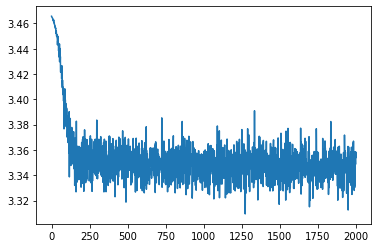

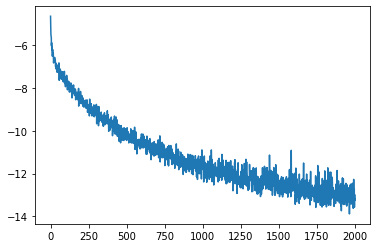

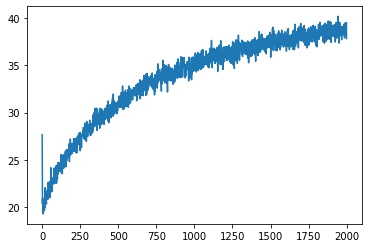

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_gnns)
plt.show()
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_distances)
plt.show()
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_shuffles)
plt.show()

In [13]:
# learn model1 done, frozen model1
for i in model1.parameters():
    model1.requires_grad = False
model1.eval()
# generate adj for all graphs
with torch.no_grad():
    graphs = []
    print("u", u)
    for i in range(args.n_graphs):
        _, X, L = gen_graph(n=args.n, p=args.p, lam=args.lam, mu=args.mu, u=u)
        A = model1.predict_adj([X], absolute=True)[0]
        graphs.append((A, X, L, None))
train_graphs = graphs[:train_size]
test_graphs = graphs[train_size:]

# for graph in graphs:
#     print(graph[0].sum()/len(graph[0]))

u [[-0.61863552  0.12115582  0.40765972 -0.08924962  0.34694929  0.18180381
   0.07819882 -0.37831745]]


In [14]:
print(args.n*(args.n-1)//2)
for i in range(10):
    print(sum(graphs[0][0] == graphs[i][0]))
print()
for i in range(10):
    print(graphs[i][0][:10])

496
tensor(496, device='cuda:0')
tensor(273, device='cuda:0')
tensor(248, device='cuda:0')
tensor(239, device='cuda:0')
tensor(220, device='cuda:0')
tensor(293, device='cuda:0')
tensor(281, device='cuda:0')
tensor(303, device='cuda:0')
tensor(286, device='cuda:0')
tensor(253, device='cuda:0')

tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([1., 1., 1., 0., 0., 0., 0., 1., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 1., 1., 0., 1.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 0., 1., 1., 0., 1.], device='cuda:0')
tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 1., 1., 1., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 1., 0., 1., 1., 0., 1., 0., 1., 0.], device='cuda:0')
tensor([1., 1., 1., 1., 1., 0., 0., 0., 1., 0.], device='cuda:0')


In [15]:
# learn model2
model2 = ModelSigmoid().to(device) # another model that learns function F
print(model2)
optim = torch.optim.Adam(model2.parameters(), lr=0.01) # weight_decay=5e-4
loss_fn = nn.BCELoss()

halfAs = [x[0] for x in graphs]
train_halfAs = halfAs[:train_size]
test_halfAs = halfAs[train_size:]

ModelSigmoid(
  (W): Sequential(
    (FtqY-linear1): Linear(in_features=496, out_features=992, bias=True)
    (FtqY-relu1): ELU(alpha=1.0)
    (FtqY-linear4): Linear(in_features=992, out_features=496, bias=True)
  )
)


In [16]:
for iter in range(5000):   
    model2.train()
    optim.zero_grad()
    inds = np.random.permutation(len(train_graphs))[:args.batch_size]
    batch_xs = [train_graphs[x][1] for x in inds]
    batch_halfAs = [train_halfAs[x] for x in inds]
    pred_As, batch_halfAs = model2.forward_shuffle(batch_xs, batch_halfAs)
    loss = loss_fn(pred_As, batch_halfAs)
    loss.backward()
    optim.step()
    
    if iter % 100 == 0 or iter == 1:
        model2.eval()
        with torch.no_grad():
            batch_xs = batch_xs[:5] + [x[1] for x in test_graphs]
            batch_halfAs = [x for x in batch_halfAs[:5]] + test_halfAs
            pred_As = model2.predict_adj(batch_xs, absolute=True)
            microfs = [compute_f1(predA, halfA) for predA, halfA in zip(pred_As, batch_halfAs)]
            microstr = " ".join([f"{f1:.2f}" for f1 in microfs])
            print(f"Iter {iter} - loss {loss:.10f} - f1 {microstr}")

Iter 0 - loss 1.0476177931 - f1 0.49 0.50 0.50 0.52 0.56 0.51 0.46
Iter 1 - loss 3.8916194439 - f1 0.55 0.50 0.49 0.49 0.53 0.49 0.52
Iter 100 - loss 12.8764810562 - f1 0.44 0.45 0.46 0.44 0.44 0.40 0.45
Iter 200 - loss 13.2665500641 - f1 0.45 0.45 0.43 0.43 0.41 0.41 0.45
Iter 300 - loss 13.3160600662 - f1 0.44 0.43 0.43 0.44 0.44 0.40 0.45
Iter 400 - loss 13.3741502762 - f1 0.42 0.46 0.43 0.40 0.43 0.38 0.44
Iter 500 - loss 13.4348220825 - f1 0.42 0.44 0.42 0.42 0.41 0.39 0.44
Iter 600 - loss 13.6567306519 - f1 0.40 0.38 0.41 0.42 0.43 0.39 0.44
Iter 700 - loss 13.6027822495 - f1 0.44 0.44 0.39 0.42 0.42 0.38 0.44
Iter 800 - loss 13.1731748581 - f1 0.44 0.44 0.42 0.45 0.47 0.39 0.44
Iter 900 - loss 13.3155593872 - f1 0.44 0.44 0.42 0.41 0.43 0.38 0.44
Iter 1000 - loss 13.3363199234 - f1 0.42 0.45 0.45 0.43 0.40 0.38 0.44
Iter 1100 - loss 13.2807626724 - f1 0.42 0.44 0.44 0.42 0.42 0.38 0.44
Iter 1200 - loss 13.5802888870 - f1 0.41 0.44 0.40 0.41 0.42 0.38 0.44
Iter 1300 - loss 13.719

In [115]:
# for i in model1.parameters():
#     print(i)
# print()
# for i in model2.parameters():
#     print(i)

In [17]:
def save_graphs(A, X, L, outdir):
    print(f"\n==== Save graphs to {outdir}")
    dataname = outdir.split("/")[-1]
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    np.savetxt(outdir + f"/{dataname}.txt", A, fmt="%.4f", delimiter=" ")
    with open(outdir + "/labels.txt", "w+") as fp:
        for i, label in enumerate(L):
            fp.write(f"{i} {label}\n")
    np.savez_compressed(outdir + "/features.npz", features=X)
    print("=== Done ===\n")

# G(Atrain, Xtrain)
model2.eval()
halfA, X, L, _ = train_graphs[0]
A = halfA_to_A(halfA.cpu().numpy())
print('Atrain-Xtrain')
save_graphs(A, X, L, f"data-transfers/synf-seed{args.seed}/Atrain-Xtrain")

_, X, L, _ = test_graphs[0]
with torch.no_grad():
    halfA = model2.predict_adj([X])[0]
A = halfA_to_A(halfA.cpu().numpy())
print('Atest-Xtest')
save_graphs(A, X, L, f"data-transfers/synf-seed{args.seed}/A2-Xtest")

Atrain-Xtrain

==== Save graphs to data-transfers/synf-seed100/Atrain-Xtrain
=== Done ===

Atest-Xtest

==== Save graphs to data-transfers/synf-seed100/A2-Xtest
=== Done ===



In [18]:
# transfer 
scripts="""
export CUDA_VISIBLE_DEVICES=1
seed=100
echo $seed
datadir=data-transfers/synf-seed$seed
echo "Training from scratch Atrain-Xtrain"
name=Atrain-Xtrain
python -W ignore -u main.py --adj $datadir/$name/$name.txt --labels $datadir/$name/labels.txt \
    --features $datadir/$name/features.npz --seed $seed --epochs 300 --feature-only

echo "Training from scratch A2-Xtest"
name=A2-Xtest
python -W ignore -u main.py --adj $datadir/$name/$name.txt --labels $datadir/$name/labels.txt \
    --features $datadir/$name/features.npz --seed $seed --epochs 300 --feature-only

echo "Transfer Atrain-Xtrain to A2-Xtest"
python -W ignore -u main.py --adj $datadir/$name/$name.txt --labels $datadir/$name/labels.txt \
    --features $datadir/$name/features.npz \
    --transfer model/Atrain-Xtrain.pkl --seed $seed --epochs 0 --feature-only
"""
with open("temp_scripts_dat.sh", "w+") as fp:
    fp.write(scripts)
!sh temp_scripts_dat.sh

100
Training from scratch Atrain-Xtrain
Namespace(adj='data-transfers/synf-seed100/Atrain-Xtrain/Atrain-Xtrain.txt', epochs=300, feature_only=True, features='data-transfers/synf-seed100/Atrain-Xtrain/features.npz', hidden=32, labels='data-transfers/synf-seed100/Atrain-Xtrain/labels.txt', multiclass=None, seed=100, transfer=None)
Found adj file data-transfers/synf-seed100/Atrain-Xtrain/Atrain-Xtrain.txt
Multiclass:  False
train mask tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1], dtype=torch.uint8)
val mask tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)
Num features: 8
Num classes: 2
Using softmax regression
Epoch: 0, micro-macro Train: 0.0400-0.0385, Val: 0.0000-0.0000, Test: 0.0000-0.0000
Epoch: 020, micro-macro Train: 0.1200-0.1071, Val: 0.0000-0.0000, Test: 0.0000-0.0000
Epoch: 040, micro-macro Train: 0.1200-0.1071, Val: 0.1429-0.1250,

In [98]:
!nvidia-smi

Sun Feb  2 02:50:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:09:00.0 Off |                  N/A |
|  0%   44C    P8     8W / 260W |  10835MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:42:00.0 Off |                  N/A |
|  0%   49C    P8    21W / 260W |    979MiB / 11016MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        